In [14]:
import os
os.environ["LANGCHAIN_TRACING_V2"] = "false"
os.environ["LANGCHAIN_TRACING"] = "false"
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['OPENAI_API_KEY'] = 

In [15]:

from langchain.text_splitter import RecursiveCharacterTextSplitter
from pathlib import Path
import pandas as pd
from langchain import hub
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

DATA_DIR = Path("/Users/titus.w/Code/MyProfile/GitHub/RAG-Project/p1_rag_tutorial/research-presentation/")          # 三个文件所在目录
files = ["data1.xlsx", "data2.xlsx", "data3.xlsx"]

dfs = []
for f in files:
    file_path = DATA_DIR / f
    if not file_path.exists():
        raise FileNotFoundError(file_path)
    

    xl = pd.ExcelFile(file_path)
    for sheet in xl.sheet_names:
        df = xl.parse(sheet)
        df["__source_file__"] = f"{f}:{sheet}"
        dfs.append(df)

raw_df = pd.concat(dfs, ignore_index=True)

clean_df = (
    raw_df
    .dropna(how="all")
    .applymap(lambda x: str(x).strip() if pd.notna(x) else x)
    .drop_duplicates()
)

documents = []
for idx, row in clean_df.iterrows():
    content = f"问：{row['问题']}\n答：{row['答案']}\n来源：{row['__source_file__']}"
    metadata = {
        "row_index": int(idx),
        "source": row["__source_file__"],
    }
    documents.append(Document(page_content=content, metadata=metadata))

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    length_function=len,
)
splits = text_splitter.split_documents(documents)

# Embed
vectorstore = Chroma.from_documents(documents=splits, 
                                    embedding=OpenAIEmbeddings())
retriever = vectorstore.as_retriever()
print(f"处理完成，写入向量条目数：{vectorstore._collection.count()}")


# Prompt
prompt = hub.pull("rlm/rag-prompt")

# LLM
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)


rag_chain.invoke("什么是大数据?")


/var/folders/gt/v4c_6cv52lgdw4xwjdrl8z8c0000gn/T/ipykernel_31309/480133866.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  raw_df


处理完成，写入向量条目数：3416


'大数据是指无法在一定时间范围内用常规软件工具进行捕捉、管理和处理的数据集合，具有大量、高速、多样、价值密度低等特点。'

### Multi Query

In [16]:
# Multi Query: Different Perspectives
from langchain.prompts import ChatPromptTemplate
template = """您是一个AI语言模型助手。您的任务是生成五个不同版本的用户问题，以从向量数据库中检索相关文档。
通过从多个角度生成用户问题，您的目标是帮助用户克服基于距离的相似性搜索的一些局限性。
请提供这些替代问题，每个问题之间用换行符分隔。 初始问题: {question}"""
prompt_perspectives = ChatPromptTemplate.from_template(template)

from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

generate_queries = (
    prompt_perspectives 
    | ChatOpenAI(temperature=0) 
    | StrOutputParser() 
    | (lambda x: x.split("\n"))
)
from langchain.load import dumps, loads

def get_unique_union(documents: list[list]):
    """ Unique union of retrieved docs """
    # Flatten list of lists, and convert each Document to string
    flattened_docs = [dumps(doc) for sublist in documents for doc in sublist]
    # Get unique documents
    unique_docs = list(set(flattened_docs))
    # Return
    return [loads(doc) for doc in unique_docs]

# Retrieve
question = "什么是大数据?"
retrieval_chain = generate_queries | retriever.map() | get_unique_union
docs = retrieval_chain.invoke({"question":question})
len(docs)
def pretty_print_docs(docs):
    """
    将 LangChain Document 列表按“问题n / 回答n”格式打印
    """
    for i, doc in enumerate(docs, 1):
        # 按换行切分“问：…\n答：…”
        parts = doc.page_content.split("\n", 1)
        question = parts[0].replace("问：", "").strip() if parts else ""
        answer   = parts[1].replace("答：", "").strip() if len(parts) > 1 else ""
        
        print(f"问题{i}：{question}")
        print(f"回答{i}：{answer}")
        print("-" * 60)
pretty_print_docs(docs)
from operator import itemgetter
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnablePassthrough

# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

llm = ChatOpenAI(temperature=0)

final_rag_chain = (
    {"context": retrieval_chain, 
     "question": itemgetter("question")} 
    | prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"question":question})

问题1：大数据的价值体现在哪些方面？
回答1：为企业提供决策支持、优化业务流程、发现新的商业机会、提升客户体验等。
来源：data1.xlsx:Sheet1
------------------------------------------------------------
问题2：大数据分析如何帮助企业进行决策？
回答2：大数据分析为企业提供了强大的数据支持，使决策者能够基于实证数据发现新的商业机会、评估潜在风险，并优化业务流程。这种数据驱动的决策模式能够提高企业的竞争力和市场适应性。
来源：data1.xlsx:Sheet1
------------------------------------------------------------
问题3：什么是大数据？
回答3：答案：大数据是指无法在一定时间范围内用常规软件工具进行捕捉、管理和处理的数据集合，具有大量、高速、多样、价值密度低等特点。
来源：data1.xlsx:Sheet1
------------------------------------------------------------
问题4：大数据在行业或领域有哪些应用情况？
回答4：大数据无处不在，包括金融、汽车、餐饮、电信、能源、体育和娱乐等在内的社会各行各业都已经融入了大数据的印迹，下表是大数据在各个领域的应用情况。任答两个都可以。
来源：data1.xlsx:Sheet1
------------------------------------------------------------
问题5：大数据对社会发展的影响有哪些？
回答5：推动科技创新、提高决策效率、促进经济发展等。
来源：data1.xlsx:Sheet1
------------------------------------------------------------


'大数据是指无法在一定时间范围内用常规软件工具进行捕捉、管理和处理的数据集合，具有大量、高速、多样、价值密度低等特点。'

### RAG-Fusion（Re-ranking）

In [17]:
# RAG-Fusion: Related
from langchain.prompts import ChatPromptTemplate
template = """您是一个有用的助手，可以根据单个输入查询生成多个搜索查询。 \n
生成多个与之相关的搜索查询: {question} \n
输出（4个查询）:"""
prompt_rag_fusion = ChatPromptTemplate.from_template(template)
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

generate_queries = (
    prompt_rag_fusion 
    | ChatOpenAI(temperature=0)
    | StrOutputParser() 
    | (lambda x: x.split("\n"))
)
from langchain.load import dumps, loads

def reciprocal_rank_fusion(results: list[list], k=60):
    """ Reciprocal_rank_fusion that takes multiple lists of ranked documents 
        and an optional parameter k used in the RRF formula """
    
    # Initialize a dictionary to hold fused scores for each unique document
    fused_scores = {}

    # Iterate through each list of ranked documents
    for docs in results:
        # Iterate through each document in the list, with its rank (position in the list)
        for rank, doc in enumerate(docs):
            # Convert the document to a string format to use as a key (assumes documents can be serialized to JSON)
            doc_str = dumps(doc)
            # If the document is not yet in the fused_scores dictionary, add it with an initial score of 0
            if doc_str not in fused_scores:
                fused_scores[doc_str] = 0
            # Retrieve the current score of the document, if any
            previous_score = fused_scores[doc_str]
            # Update the score of the document using the RRF formula: 1 / (rank + k)
            fused_scores[doc_str] += 1 / (rank + k)

    # Sort the documents based on their fused scores in descending order to get the final reranked results
    reranked_results = [
        (loads(doc), score)
        for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    ]

    # Return the reranked results as a list of tuples, each containing the document and its fused score
    return reranked_results
retrieval_chain_rag_fusion = generate_queries | retriever.map() | reciprocal_rank_fusion
docs = retrieval_chain_rag_fusion.invoke({"question": question})
len(docs)
def pretty_print(results):
    """
    支持两种输入格式：
      1. [Document, Document, ...]
      2. [(Document, score), (Document, score), ...]
    按“问题n / 回答n”友好打印；若包含 score 也一起显示。
    """
    for i, item in enumerate(results, 1):
        # 判断是否含相似度分数
        if isinstance(item, tuple):
            doc, score = item       # Tuple: (Document, score)
        else:
            doc, score = item, None # 只有 Document
        
        # 解析问答文本
        parts = doc.page_content.split("\n", 1)
        question = parts[0].replace("问：", "").strip() if parts else ""
        answer   = parts[1].replace("答：", "").strip() if len(parts) > 1 else ""
        
        # 打印
        print(f"问题{i}：{question}")
        print(f"回答{i}：{answer}")
        if score is not None:
            print(f"相似度分数：{score:.4f}")
        print("-" * 60)

# 示例调用：results 即你给出的列表
pretty_print(docs)
from langchain_core.runnables import RunnablePassthrough

# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    {"context": retrieval_chain_rag_fusion, 
     "question": itemgetter("question")} 
    | prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"question":question})

问题1：大数据技术包括哪些主要组成部分？
回答1：数据采集：通过传感器、网络爬虫、日志文件等多种方式收集数据。
数据存储：利用分布式文件系统（如HDFS）、分布式数据库等技术存储海量数据。
数据处理：对数据进行清洗、转换、规约等操作，提高数据质量。
数据分析：运用统计分析、机器学习、数据挖掘等技术从数据中提取有价值的信息。
数据可视化：将数据以直观、易懂的形式展示出来，帮助用户理解数据中的规律和趋势。
来源：data1.xlsx:Sheet1
相似度分数：0.1301
------------------------------------------------------------
问题2：什么是大数据？
回答2：大数据是指无法在一定时间范围内用常规软件工具进行捕捉、管理和处理的数据集合，具有大量（Volume）、高速（Velocity）、多样（Variety）和价值密度低（Value）等特点。这些数据集合的规模巨大，数据类型复杂多样，包括结构化、半结构化和非结构化数据，处理速度要求高，且其中蕴含的价值需要通过高级分析技术才能提取出来。
来源：data1.xlsx:Sheet1
相似度分数：0.0651
------------------------------------------------------------
问题3：大数据在行业或领域有哪些应用情况？
回答3：大数据无处不在，包括金融、汽车、餐饮、电信、能源、体育和娱乐等在内的社会各行各业都已经融入了大数据的印迹，下表是大数据在各个领域的应用情况。任答两个都可以。
来源：data1.xlsx:Sheet1
相似度分数：0.0651
------------------------------------------------------------


'Answer: 大数据是指无法在一定时间范围内用常规软件工具进行捕捉、管理和处理的数据集合，具有大量（Volume）、高速（Velocity）、多样（Variety）和价值密度低（Value）等特点。'

### Decomposition

In [18]:
from langchain.prompts import ChatPromptTemplate

# Decomposition
template = """您是一个有帮助的助手，可以生成与输入问题相关的多个子问题。\n
目标是将输入分解为一组可以单独回答的子问题/子问题。 \n
生成多个与之相关的搜索查询: {question} \n
输出（3个查询）:"""
prompt_decomposition = ChatPromptTemplate.from_template(template)

from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

# LLM
llm = ChatOpenAI(temperature=0)

# Chain
generate_queries_decomposition = ( prompt_decomposition | llm | StrOutputParser() | (lambda x: x.split("\n")))

# Run
question = "什么是大数据??"
questions = generate_queries_decomposition.invoke({"question":question})
questions

['1. 大数据是如何应用于商业和科学领域的？', '2. 大数据如何影响人们的日常生活和决策？', '3. 大数据的发展历史和未来趋势是什么？']

### Answer Recursively

In [19]:
# Prompt
template = """这里是你需要回答的问题:

\n --- \n {question} \n --- \n

这里是所有可用的背景问题 + 答案对。:

\n --- \n {q_a_pairs} \n --- \n

这里是与问题相关的额外背景信息。: 

\n --- \n {context} \n --- \n

使用上述上下文和任何背景问题 + 答案对来回答问题: \n {question}
"""

decomposition_prompt = ChatPromptTemplate.from_template(template)
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

def format_qa_pair(question, answer):
    """Format Q and A pair"""
    
    formatted_string = ""
    formatted_string += f"Question: {question}\nAnswer: {answer}\n\n"
    return formatted_string.strip()

# llm
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

q_a_pairs = ""
for q in questions:
    
    rag_chain = (
    {"context": itemgetter("question") | retriever, 
     "question": itemgetter("question"),
     "q_a_pairs": itemgetter("q_a_pairs")} 
    | decomposition_prompt
    | llm
    | StrOutputParser())

    answer = rag_chain.invoke({"question":q,"q_a_pairs":q_a_pairs})
    q_a_pair = format_qa_pair(q,answer)
    q_a_pairs = q_a_pairs + "\n---\n"+  q_a_pair
answer
from textwrap import dedent
def pretty_print_answer(text: str, as_markdown: bool = False):
    formatted = dedent(text.replace("\\n", "\n")).strip()
    if as_markdown:
        display(Markdown(formatted))
    else:
        print(formatted)

# 普通终端/Notebook 输出
pretty_print_answer(answer)

大数据的发展历史可以追溯到20世纪90年代，随着互联网的普及和数字化技术的发展，数据量急剧增加，从而催生了大数据概念的提出。随着时间的推移，大数据技术不断发展，包括数据采集、存储、处理和分析等方面的技术不断完善，大数据分析工具和平台也不断涌现，为企业和科学研究提供了更多的数据支持和洞察力。

未来，大数据的发展趋势包括人工智能与大数据的融合、实时数据分析和边缘计算等。人工智能的发展将进一步提升大数据分析的智能化水平，实时数据分析将帮助企业更快速地做出决策和应对市场变化，而边缘计算则将使数据处理更加高效和便捷。这些趋势将进一步推动大数据技术的发展，为商业和科学领域带来更多的创新和机遇。


### 逻辑路由

In [20]:
from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI

# Data model
class RouteQuery(BaseModel):

    datasource: Literal["大数据知识库", "医学知识库", "法律知识库"] = Field(
        ...,
        description="根据用户问题选择哪个数据源对回答他们的问题最相关。",
    )

# LLM with function call 
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
structured_llm = llm.with_structured_output(RouteQuery)

# Prompt 
system = """您是将用户问题路由到适当数据源的专家。
根据问题所涉及的编程语言，将其路由到相关的数据源。"""

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

# Define router 
router = prompt | structured_llm
question = """为什么Hadoop技术非常重要？
"""
result = router.invoke({"question": question})
result
result.datasource

'大数据知识库'

### 语义路由

In [21]:
from langchain.utils.math import cosine_similarity
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

# Two prompts
bigdata_template = """你是一位非常聪明的大数据专家。 \
你擅长以简洁易懂的方式回答有关大数据的问题。 \
当你不知道问题的答案时，你承认你不知道。

Here is a question:
{query}"""

math_template = """你是一个非常优秀的数学家。你擅长回答数学问题。 \
你之所以这么厉害，是因为你能够将复杂的问题分解成各个组成部分， \
回答各个组成部分，然后将它们结合起来回答更广泛的问题。

Here is a question:
{query}"""

# Embed prompts
embeddings = OpenAIEmbeddings()
prompt_templates = [bigdata_template, math_template]
prompt_embeddings = embeddings.embed_documents(prompt_templates)

# Route question to prompt 
def prompt_router(input):
    # Embed question
    query_embedding = embeddings.embed_query(input["query"])
    # Compute similarity
    similarity = cosine_similarity([query_embedding], prompt_embeddings)[0]
    most_similar = prompt_templates[similarity.argmax()]
    # Chosen prompt 
    print("Using MATH" if most_similar == math_template else "Using PHYSICS")
    return PromptTemplate.from_template(most_similar)


chain = (
    {"query": RunnablePassthrough()}
    | RunnableLambda(prompt_router)
    | ChatOpenAI()
    | StrOutputParser()
)

print(chain.invoke("什么是大数据?"))

Using PHYSICS
大数据是指海量、多样化、高速产生的数据集合。这些数据量大到传统数据处理工具难以处理，但通过大数据技术和工具可以进行有效的分析和挖掘，以获取有价值的信息和洞察。


### Clustering Idex

/var/folders/gt/v4c_6cv52lgdw4xwjdrl8z8c0000gn/T/ipykernel_31309/3433576282.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  raw_df = raw_df.applymap(lambda x: str(x).strip() if pd.notna(x) else x).drop_duplicates()


原始文档数：846
--------------------------------------------------------------------------------
切分后文档块数：851
嵌入维度： 1536


/Users/titus.w/opt/anaconda3/envs/rag3.9/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27599 (\N{CJK UNIFIED IDEOGRAPH-6BCF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/titus.w/opt/anaconda3/envs/rag3.9/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 31751 (\N{CJK UNIFIED IDEOGRAPH-7C07}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/titus.w/opt/anaconda3/envs/rag3.9/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25991 (\N{CJK UNIFIED IDEOGRAPH-6587}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/titus.w/opt/anaconda3/envs/rag3.9/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26723 (\N{CJK UNIFIED IDEOGRAPH-6863}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/titus.w/opt/anaconda3/envs/rag3.9/lib/python3.9/site-packages/IPython/core/pylabt

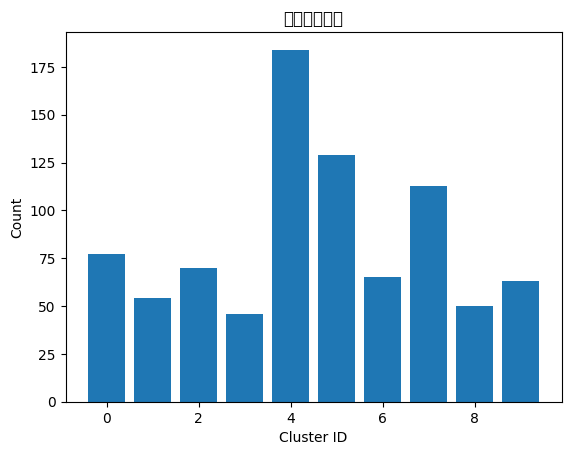


原始检索文档示例：
[Doc 1] 问：什么是大数据？
答：大数据是指无法在一定时间范围内用常规软件工具进行捕捉、管理和处理的数据集合，具有大量（Volume）、高速（Velocity）、多样（Variety）和价值密度低（Value）等特点。这些数据集合的规模巨大，数据类型…  (data1.xlsx:Sheet1)
[Doc 2] 问：大数据的“4V”特性是什么？
答：Volume（大量）、Velocity（高速）、Variety（多样）、Value（价值密度低），共同定义了数据的规模、实时性、类型广泛性和信息价值。…  (data1.xlsx:Sheet1)
[Doc 3] 问：大数据与传统数据的主要区别是什么？
答：规模：大数据的规模远大于传统数据，可以达到PB级甚至EB级。
类型：大数据类型多样，包括结构化、半结构化和非结构化数据，而传统数据主要是结构化数据。
处理速度：大数据要求极高的处理速度，以实现实时…  (data1.xlsx:Sheet1)
[Doc 4] 问：列举三个常见的大数据来源。
答：大数据采集可以通过多种方法实现，包括但不限于传感器采集、网络爬虫、日志文件采集以及数据库抽取。这些方法使我们能够从各种来源收集所需的数据。…  (data1.xlsx:Sheet1)
[Doc 5] 问：大数据技术包括哪些主要组成部分？
答：数据采集：通过传感器、网络爬虫、日志文件等多种方式收集数据。
数据存储：利用分布式文件系统（如HDFS）、分布式数据库等技术存储海量数据。
数据处理：对数据进行清洗、转换、规约等操作，提高数据质量。…  (data1.xlsx:Sheet1)

聚类后文档分布：

=== 簇 0 | 文档数 77 ===
- 问：简述Hadoop和谷歌的MapReduce、GFS等技术之间的关系。 ...
- 问：简述在 Reduce 端的 Shuffle 过程。 ...
- 问：简述什么是Combiner函数，它的主要作用。 ...

=== 簇 1 | 文档数 54 ===
- 问：什么是数据仓库？ ...
- 问：如何确保大数据采集的准确性？ ...
- 问：大数据采集过程中可能遇到哪些问题？如何解决？ ...

=== 簇 2 | 文档数 70 ===
- 问：简述UMP系统如何实现容灾的。 ...
- 问：简述UMP系统中主

In [22]:
from pathlib import Path
import pandas as pd
from langchain.docstore.document import Document

DATA_DIR = Path("/Users/titus.w/Code/MyProfile/GitHub/RAG-Project/p1_rag_tutorial/research-presentation/")   # 调整为实际路径
excel_files = ["data1.xlsx", "data2.xlsx", "data3.xlsx"]

dfs = []
for fn in excel_files:
    xl = pd.ExcelFile(DATA_DIR / fn)
    for sheet in xl.sheet_names:
        df = xl.parse(sheet)
        df["__source__"] = f"{fn}:{sheet}"
        dfs.append(df)

raw_df = pd.concat(dfs, ignore_index=True).dropna(how="all")
raw_df = raw_df.applymap(lambda x: str(x).strip() if pd.notna(x) else x).drop_duplicates()

documents = [
    Document(
        page_content=f"问：{row['问题']}\n答：{row['答案']}",
        metadata={"source": row["__source__"], "row": int(idx)},
    )
    for idx, row in raw_df.iterrows()
]

print(f"原始文档数：{len(documents)}")
print("-" * 80)

from langchain.text_splitter import RecursiveCharacterTextSplitter

splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = splitter.split_documents(documents)
print(f"切分后文档块数：{len(chunks)}")

from langchain.embeddings.openai import OpenAIEmbeddings
import numpy as np


emb = OpenAIEmbeddings()
emb_vectors = np.array(emb.embed_documents([c.page_content for c in chunks]))
print("嵌入维度：", emb_vectors.shape[1])


from math import sqrt
from sklearn.cluster import KMeans


k = max(2, min(10, int(sqrt(len(chunks) / 2))))
kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
labels = kmeans.fit_predict(emb_vectors)


import matplotlib.pyplot as plt
import numpy as np

unique, counts = np.unique(labels, return_counts=True)
plt.bar(unique, counts)
plt.title("每簇文档数量")
plt.xlabel("Cluster ID")
plt.ylabel("Count")
plt.show()


print("\n原始检索文档示例：")
for i, doc in enumerate(documents[:5], 1):
    print(f"[Doc {i}] {doc.page_content[:120]}…  ({doc.metadata['source']})")


cluster_docs = {cid: [] for cid in unique}
for doc, cid in zip(chunks, labels):
    cluster_docs[cid].append(doc)

print("\n聚类后文档分布：")
for cid in sorted(cluster_docs):
    print(f"\n=== 簇 {cid} | 文档数 {len(cluster_docs[cid])} ===")
    for d in cluster_docs[cid][:3]:  # 每簇仅示例打印 3 条
        print("-", d.page_content.split("\n")[0][:80], "...")


from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate

llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

summary_prompt = PromptTemplate.from_template(
    """请用中文概括以下文档片段的主要主题和关键信息，不超过 80 字：
    {texts}"""
)

cluster_summaries = {}
for cid, docs_in_cluster in cluster_docs.items():
    # 取前 few 条拼接文本（太长会超 context，可自行调整数量）
    sample_text = "\n\n".join(d.page_content[:400] for d in docs_in_cluster[:8])
    resp = llm.predict(summary_prompt.format(texts=sample_text))
    cluster_summaries[cid] = resp.strip()


print("\n每个簇的总结：")
for cid, summ in sorted(cluster_summaries.items()):
    print(f"簇 {cid}：{summ}")


from collections import Counter
final_topics = Counter(cluster_summaries.values()).most_common()
print("\n🏁 主题汇总（出现次数降序）：")
for topic, freq in final_topics:
    print(f"{freq} × {topic}")